# Hundley - Starbucks Rewards Project
A project completed as the capstone project for Udacity's Machine Learning Engineer nanodegree program!

It’s no secret that I’m a big fan of Starbucks! I visit Starbucks perhaps two to three times per week. A daddy to two little girls under two years old, I often leverage one of our local Starbucks locations as a getaway means to study or focus on projects… like this one.

## Project Overview

As a means to attract and retain customers, Starbucks leverages a rewards program that honors regular customers with special offers not available to the standard customer. For this project, we'll be combing through some fabricated customer and offer data provided by Starbucks / Udacity to understand how Starbucks may choose to alter its rewards program to better suit specific customer segments.

## Problem Statement

The problem we are looking to solve here is conceptually easy to understand, albeit difficult to answer. **We are looking to best determine which kind of offer to send to each customer segment based on their purchasing decisions.** We’ll touch more on what these offers are and data we’ll be utilizing down in the next section. We will leverage traditional evaluation metrics to determine which model is most appropriate for our dataset. These evaluation metrics will be discussed in an upcoming section.

## Project Metrics

Given that we will be leveraging unsupervised clustering models for our project, we will be using some metrics that enable us to validate our clusters without having labelled data. Namely, we will be leveraging the silhouette coefficient. Because we don’t have labelled data, the silhouette coefficient is appropriate since it produces a score between the range of -1 and 1 based on internal indices. It also happens to be easy to calculate with help from sci-kit learn.

Additionally, we will be leveraging the elbow method of determining k-means clusters through a simple function that will iterate through a number of K-Means clusters and displaying the Sum of Squared Errors (SSE) in visual form. This in conjunction with the silhouette coefficient will idealize the number of clusters for our final algorithm.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Project Initialization

Before we jump into our project, let's set ourselves up for success by first importing the packages we'll be leveraging as well as importing our datasets that Udacity has kindly provided for us.

In [2]:
#Importing everything we'll need

#General Packages
import math
import json
import os
import datetime

#PyData Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

#Sklearn Packages
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#Magic Commands
%matplotlib inline

In [3]:
#Reading in the json files
portfolio = pd.read_json('data/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('data/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('data/transcript.json', orient = 'records', lines = True)

## Initial Analysis & Data Preproccesing

With our packages and data imported, we'll move on by performing a lightweight analysis on the dataset to determine what pieces need preprocessed before we move on into the next section. We'll do this for each of our three datasets.

### Portfolio Dataset

#### Initial Analysis

In [3]:
#Looking at the first fiew rows of the portfolio dataset
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
#Looking at datatypes and completeness of portfolio dataset
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
#Viewing all the offer_types that are offered
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [6]:
#Viewing all the channels leveraged
portfolio['channels'].value_counts()

[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

#### Portfolio Clean Up

Since this is a relatively small dataset, there isn't much to change. That said, we'll clean up these pieces here:

- Change the column name from 'id' to the more descriptive 'offer_id' since the id column is present in our other datasets
- One hot encode the 'offer_type' column to work well with our algorithms later
- Separate and one hot encode the 'channels' column to also work with our algorithms later
- Drop 'offer_type' and 'channels' columns now that they are one hot encoded

In [7]:
#Changing the column name from 'id' to 'offer_id'
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_id      10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
#One hot encoding the offer_type field, fixing a prefix of 'offer'
offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
portfolio = pd.concat([portfolio, offer_dummies], axis = 1)

#Viewing our changes
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,offer_bogo,offer_discount,offer_informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0


In [9]:
#Separating and one hot encoding the channels field
#Special thanks to this post for assistance: https://chrisalbon.com/machine_learning/preprocessing_structured_data/one-hot_encode_features_with_multiple_labels/

#Initializing our MultiLabelBinarizer object
channels_one_hot = MultiLabelBinarizer()

#One hot encoding the data
sep_channels = channels_one_hot.fit_transform(portfolio['channels'])

#Building a DataFrame around these channels
channels_df = pd.DataFrame(data = sep_channels, columns = channels_one_hot.classes_)

#Concatenating the new columns to our primary 'portfolio' DataFrame
portfolio = pd.concat([portfolio, channels_df], axis = 1)

#Changing the column names to affix 'channels_' prefix
portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)

#Viewing our changes
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


In [10]:
#Dropping the now former 'channels' and 'offer_type' columns
portfolio.drop(columns = ['channels', 'offer_type'], axis = 1, inplace = True)

#Viewing our hanges
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
difficulty             10 non-null int64
duration               10 non-null int64
offer_id               10 non-null object
reward                 10 non-null int64
offer_bogo             10 non-null uint8
offer_discount         10 non-null uint8
offer_informational    10 non-null uint8
channel_email          10 non-null int64
channel_mobile         10 non-null int64
channel_social         10 non-null int64
channel_web            10 non-null int64
dtypes: int64(7), object(1), uint8(3)
memory usage: 750.0+ bytes


### Profile Dataset

#### Initial Analysis

In [11]:
#Looking at the first few rows
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
#Checking for data completeness and datatypes
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
#Cheking gender types and leaving in the nulls
profile['gender'].value_counts(dropna = False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

In [14]:
#Checking how many unknown ages (118) are in the dataset
(profile['age'] == 118).sum()

2175

#### Profile Clean Up

Because this dataset is bigger, we'll have to make some more changes to it than our previous datasets. These changes include the following:

 - Dropping rows with null information
 - Changing 'id' column to 'customer_id' name
 - Changing the 'became_member_on' column to a date object type
 - Calculating number of days that a person has been a member as new 'days_as_member' column as of August 1, 2018
 - Creating new 'age_range' column based on 'age'

In [15]:
#Dropping rows with null information
profile.dropna(inplace = True)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [16]:
#Changing 'id' column name to more appropriate 'customer_id' name
profile.rename(columns = {'id': 'customer_id'}, inplace = True)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
customer_id         14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [17]:
#Changing 'became_member_on' column to a date type
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())
profile['became_member_on'].head()

1     2017-07-15
3     2017-05-09
5     2018-04-26
8     2018-02-09
12    2017-11-11
Name: became_member_on, dtype: object

In [18]:
#Calculating number of days as a member ending on August 1, 2018 in new column 'days_as_member'
#Special thanks to this post for assistance: https://stackoverflow.com/questions/26072087/pandas-number-of-days-elapsed-since-a-certain-date
end_date = pd.Timestamp('2018-08-01')
end_date = pd.to_datetime(end_date)
profile['days_as_member'] = np.abs((pd.to_datetime(profile['became_member_on']) - end_date).dt.days)

#Viewing results
profile['days_as_member'].head(10)

1      382
3      449
5       97
8      173
12     263
13     324
14    1630
15     902
16    1357
18     213
Name: days_as_member, dtype: int64

In [19]:
#Creating 'age_range' column based on 'age'
#Special thanks to this post for assistance: https://stackoverflow.com/questions/52753613/grouping-categorising-ages-column-in-python-pandas
age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_labels, right = False)

#Adding a specific order to the age_range_field
#Special thanks to this post for assistance: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html
profile['age_range'] = pd.Categorical(profile['age_range'], ordered = True, categories = age_range_labels)

#Testing our results
profile.sample(5)

,age,became_member_on,gender,customer_id,income,days_as_member,age_range
11615,56,2018-04-23,M,c1cd465847e2488482d863ff5ff15a20,37000.0,100,50-59
12876,87,2015-08-29,F,d27b2ed395fc4f1d814de65eb0815c95,86000.0,1068,80+
9609,86,2017-11-05,F,9643b1f0557945f2940b96743fd128e4,70000.0,269,80+
10029,55,2018-01-10,F,119a7e0359554181b0f9a502ac351ad5,80000.0,203,50-59
4178,37,2014-05-22,M,63674022d72c4993a8f6c5edcbf01dcc,38000.0,1532,30-39


### Transcript Dataset

#### Initial Analysis

In [20]:
#Looking at the first few rows
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
#Checking for null values and datatypes
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
#Checking out the event types
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [23]:
transcript.sample(10)

,event,person,time,value
297830,transaction,5293428f33b0427e8dcbbf9c46d77d6e,672,{'amount': 4.21}
79295,offer completed,43bd55b2d84447b592dcd9b2e04f392b,192,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
157270,offer received,3693bd7f86844b51abf47b035fe3bc0a,408,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
80695,transaction,131a2c60165f4ff8995e0dadbcf090e9,198,{'amount': 16.51}
170945,transaction,3f8e7c0539114da19f91e39d11746024,414,{'amount': 7.69}
74055,transaction,133a58e4ebdf45dd9e8f48325bdb22f4,180,{'amount': 8.22}
279227,transaction,d674b3444fa74d15a61baa3c882f4c20,612,{'amount': 3.41}
212655,offer received,3c18c8aca33849569b36c6636a44834c,504,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
128333,offer viewed,46bff6d3b8fb462880a0d476c3945c33,342,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
269230,offer completed,f8e6f303728449f0a610f7fce625d1da,594,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...


#### Transcript Clean Up

 - Change name of 'person' column to 'customer_id'
 - Remove customers that are not reflected in the 'profile' dataset
 - One hot encode the 'event' values
 - Change 'time' column to 'days' along with the appropriate values
 - Separate value from key in 'value' dictionary to form two new DataFrames: transcript_offer and transcript_amount

In [24]:
#Changing the 'person' category name to 'customer_id'
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event          306534 non-null object
customer_id    306534 non-null object
time           306534 non-null int64
value          306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
#Remove customers not found in the 'profile dataset'
#Special thanks to this post for assistance with this https://datacarpentry.org/python-ecology-lesson/05-merging-data/
transcript = pd.merge(left = transcript, right = profile, how = 'inner', left_on = 'customer_id', right_on = 'customer_id')
transcript.drop(columns = ['age', 'became_member_on', 'gender', 'income', 'days_as_member', 'age_range'], inplace = True)

#Testing for success
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 4 columns):
event          272762 non-null object
customer_id    272762 non-null object
time           272762 non-null int64
value          272762 non-null object
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


In [26]:
#One hot encode the 'event' values
#Special thanks to this page for assistance: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
event_dummies = pd.get_dummies(transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
transcript = pd.concat([transcript, event_dummies], axis = 1)
transcript.head()

,event,customer_id,time,value,offer_completed,offer_received,offer_viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},0,0,0,1
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1,0,0,0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},0,0,0,1


In [27]:
#Change 'time' column to 'days' along with the appropriate values
transcript['days'] = transcript['time'] / 24
transcript.drop(columns = ['time'], inplace = True)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 8 columns):
event              272762 non-null object
customer_id        272762 non-null object
value              272762 non-null object
offer_completed    272762 non-null uint8
offer_received     272762 non-null uint8
offer_viewed       272762 non-null uint8
transaction        272762 non-null uint8
days               272762 non-null float64
dtypes: float64(1), object(3), uint8(4)
memory usage: 11.4+ MB


In [28]:
#Separate value from key in 'value' dictionary to form two new DataFrames: transcript_offer and transcript_amount
#Special thanks to this post for help: https://stackoverflow.com/questions/35711059/extract-dictionary-value-from-column-in-data-frame

#Initial separation
transcript['offer-or-amount'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['id-or-amount'] = transcript['value'].apply(lambda x: list(x.values())[0])

#Conforming 'offer id' to read 'offer_id' consistently
trans_offer_dict = {'offer id': 'offer_id'}
transcript['offer-or-amount'].replace(trans_offer_dict, inplace = True)

#Creating the transcript_offer DataFrame
transcript_offer = transcript[transcript['offer-or-amount'] == 'offer_id']
transcript_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
transcript_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)

#Creating the transcript_amount DataFrame
transcript_amount = transcript[transcript['offer-or-amount'] == 'amount']
transcript_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
transcript_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)

transcript_amount.head(10)

/Users/dkhundley/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/dkhundley/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,customer_id,transaction,days,amount
2,78afa995795e4d85b5d9ceeca43f5fef,1,5.50,19.89
4,78afa995795e4d85b5d9ceeca43f5fef,1,6.00,17.78
7,78afa995795e4d85b5d9ceeca43f5fef,1,9.25,19.67
8,78afa995795e4d85b5d9ceeca43f5fef,1,10.00,29.72
9,78afa995795e4d85b5d9ceeca43f5fef,1,15.75,23.93
13,78afa995795e4d85b5d9ceeca43f5fef,1,21.25,21.72
16,78afa995795e4d85b5d9ceeca43f5fef,1,22.25,26.56
20,e2127556f4f64592b11af22de27a7932,1,12.00,17.88
21,e2127556f4f64592b11af22de27a7932,1,12.25,21.43
27,e2127556f4f64592b11af22de27a7932,1,21.75,18.42


## Exploratory Data Analysis

Okay! Now that we've done an initial analysis and cleaning, let's now do a more formal analysis to see how we might need to pre-process our data even further down in formal data pre-processing. We'll break this down by first looking at a question we're looking to explore (Q#) followed by an assessment on what the data actually reflects (A#).

In [29]:
#Initializing my preferred color choices
my_blue_color = '#4682B4'
my_green_color = '#8FBE00'

### Q1: What are the general age ranges of our customers?

Given the general hip, young vibe associated with Starbucks, I'm expecting this to be skewed right, meaning that we'll see more customers in those younger age ranges like 20's or 30's. Let's go ahead and verify that with a bar plot.

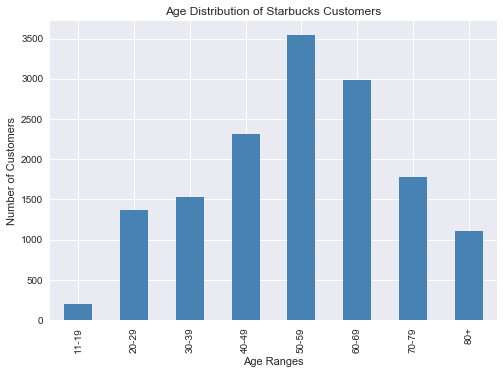

In [31]:
#Viewing the age ranges of our Starbucks customers
profile['age_range'].value_counts().sort_index().plot(kind = 'bar', color = my_blue_color);
plt.title('Age Distribution of Starbucks Customers');
plt.style.use('seaborn');
plt.ylabel('Number of Customers');
plt.xlabel('Age Ranges');

### A1: The actual age distributions of Starbucks customers.

Well, I was certainly wrong with my initial assessment! This is a classic example of why it's important to not make assumptions and let the data speak for itself. I suppose now that I think about it, I do tend to see many folks in those 40-60ish age ranges any time I visit. Perhaps it's because some of them are now retired and enjoy visiting with friends at Starbucks. Perhaps also it is that people in their twenties typically don't have the money to spend on things like Starbucks. I don't know; the data isn't particularly clear on this reasoning. No matter. Let's move on.

### Q2: What are the salary ranges of people across different age groups?

Similar to our last question, I'm curious to see how the salary ranges of these various age groups might affect how often a person visits Starbucks and utilizes their rewards program. Given our first assessment, I'm going to guess that those 40-60 age ranges have the highest salary ranges given that these people are generally further along in their careers and thus make more money to show for it. Likewise, I definitely expect those younger age ranges to be on the lower end. Let's go ahead and take a look!

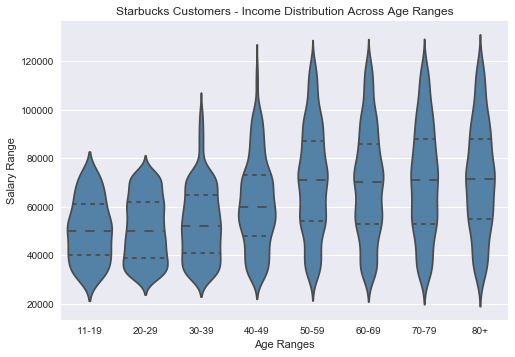

In [31]:
#Visiualizing the data in a violin plot
sb.violinplot(data = profile, x = 'age_range', y = 'income', color = my_blue_color, inner = 'quartile');
plt.title('Starbucks Customers - Income Distribution Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Salary Range');
plt.style.use('seaborn');

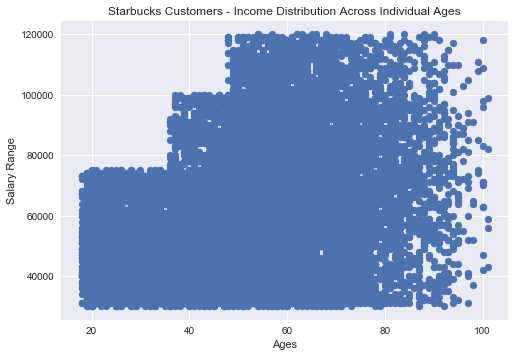

In [32]:
#Visualizing the data in a scatter plot using individual ages instead of age ranges
plt.scatter(data = profile, x = 'age', y = 'income');
plt.title('Starbucks Customers - Income Distribution Across Individual Ages');
plt.xlabel('Ages');
plt.ylabel('Salary Range');
plt.style.use('seaborn');

### A2: Analysis of Income Distribution

Okay, when first visualizing the data with the violin plots, my thoughts were affirmed that older customers definitely tend to make more money; however, I noticed something odd in the violin plot: there seemed to be a hard cap on the salary range of younger people. Visualizing the data in a scatter plot using individual ages instead of age ranges, I verified that not only are their caps for younger people, but there are caps on everybody's salaries. Looks like even for older people, the income caps out at \\$120,000. Theis seems a really odd choice on the data capturer's part. Clearly, there are many people that make more than \\$120,000 per year, and there are definitely people in their 20's and 30's that make more than that as well. Unfortunately, we're not clued at all into why these caps were put in place, so we're just going to have make due with what we've been given and note that in our finalization as well.

### Q3: What does the correlation between number of days an offer has been open vs. final transaction amount have to tell us?

Honestly, I don't know what to expect from this one, but it still has me curious. Part of me wants to believe that the longer a reward has been available, the less the person is prone to spend. My reasoning for this is that the customer clearly wasn't that excited to run out and redeem the reward right away, so the longer time would be a smaller amount because it's like a "Well, I gotta use it or lose it" kind of thing. My other hypothesis is that we're not going to see any patterns at all here, that there is no correlation at all here. Let's go ahead and let the data tell us which concept is right.

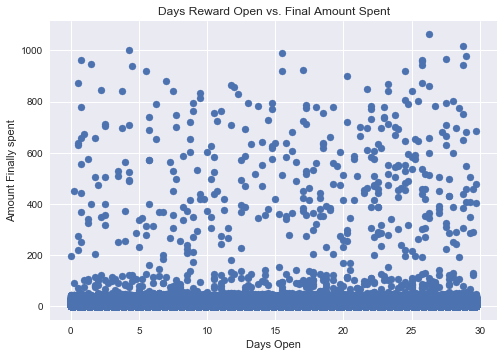

In [33]:
#Visualizing the days open vs amount spent in a scatter plot
plt.scatter(data = transcript_amount, x = 'days', y = 'amount');
plt.title('Days Reward Open vs. Final Amount Spent');
plt.xlabel('Days Open');
plt.ylabel('Amount Finally spent');
plt.style.use('seaborn');

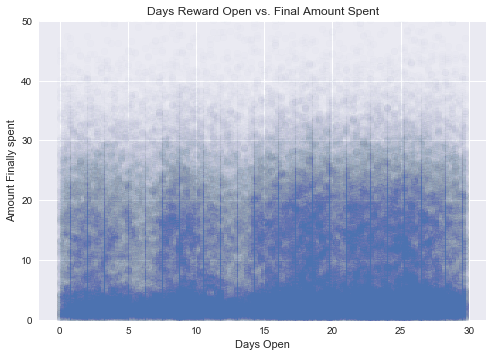

In [34]:
#Visualizing the days open vs amount spent in a scatter plot in a more limited view
plt.scatter(data = transcript_amount, x = 'days', y = 'amount', alpha = .01);
plt.title('Days Reward Open vs. Final Amount Spent');
plt.xlabel('Days Open');
plt.ylabel('Amount Finally spent');
plt.style.use('seaborn');
plt.ylim(0,50);

### A3: Analysis of Amount Spent vs. Days Open

A couple of observations here. First, I didn't realize that rewards only stretched as long as 30 days. This makes my initial curiosity of "use or lose it" tough to measure because I know as a Starbucks customer myself that I sometimes let my rewards sit out there longer than 30 days.

Second, my initial visualization wasn't all that helpful because there were surprisingly a lot of outliers of people upwards of \\$1000 in a single purchase, which is... sort of beyond me to think about. (Are these people buying the full menu...?) Anyway, this wasn't all that helpful, so I pared down the data in the next visualization. Before moving onto that, it is worth noting that even with these higher dollar amounts, there is no correlation at all between days open and amount spent.

Coming down to our pared down visualization, we again see no definitive ties between how long a reward is open and the dollar amount finally spent. As noted above, I sort of expected this, but I still am glad I got verification on that!

### Q4: Do gender distributions have any major effect on our data here?

For our final EDA piece here, let's take a look at how gender may affect our final analysis. As a reminder, our dataset has indicated three distinct genders: Male, Female, and Other.

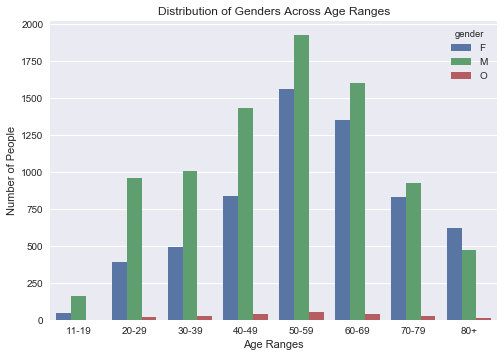

In [35]:
#Visualizing the gender distribution in a seaborn count plot
sb.countplot(data = profile, x = 'age_range', hue = 'gender');
plt.title('Distribution of Genders Across Age Ranges');
plt.xlabel('Age Ranges');
plt.ylabel('Number of People');
plt.style.use('seaborn');

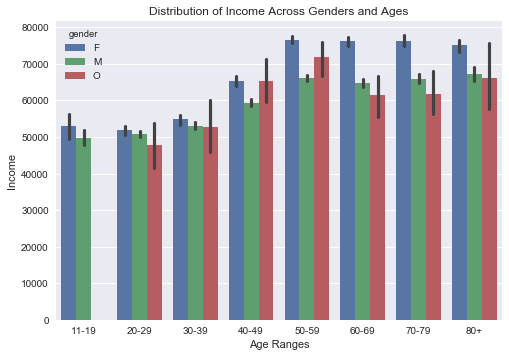

In [36]:
#Visualizing the gender/income/age range distribution in a seaborn bar plot
sb.barplot(data = profile, x = 'age_range', y = 'income', hue = 'gender');
plt.title('Distribution of Income Across Genders and Ages');
plt.xlabel('Age Ranges');
plt.ylabel('Income');
plt.style.use('seaborn');

### A4: Analysis of gender across our customer data

Several points of interest here. First, we definitely see more males across this dataset than any other gender category. In fact, the only age range we see more women is in the 80+ category, and I'm going to guess that has to do with the fact that women generally tend to live longer than men.

The other really interesting thing here is the salary distribution for women in particular. Where our dataset indicates that there are more male customers than female (or other) customers, females in this dataset generally tend to have a higher income than men. And across both the primary genders, it's not as if there's a crazy disparity between the average salary, too. This makes me curious that this data has been oddly captured since the general sentiment is that men make more than women. Why is it that this dataset falls counter to that? Unfortunately this is another one of those instances where we truly don't know given solely based on our data.

## Data Preprocessing

With initial analysis / clean up and EDA under our belt, let's move on into formalizing some data preprocessing before we move into modeling the data with some unsupervised models. First, we'll formalize what we already did above for our individual dataset into their own respective functions, and next, we'll start combining these datasets appropriately given our insights gleaned from our exploratory data analysis.

In [5]:
#Function to clean up portfolio

def clean_portfolio(portfolio = portfolio):
    #Changing the column name from 'id' to 'offer_id'
    portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
    
    #One hot encoding the offer_type field, fixing a prefix of 'offer'
    offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
    portfolio = pd.concat([portfolio, offer_dummies], axis = 1)
    
    #Separating and one hot encoding the channels field
    channels_one_hot = MultiLabelBinarizer()
    sep_channels = channels_one_hot.fit_transform(portfolio['channels'])
    channels_df = pd.DataFrame(data = sep_channels, columns = channels_one_hot.classes_)
    portfolio = pd.concat([portfolio, channels_df], axis = 1)
    portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)
    
    #Dropping the now former columns
    portfolio.drop(columns = ['channels', 'offer_type'], axis = 1, inplace = True)
    
    return portfolio

portfolio_clean = clean_portfolio()
portfolio_clean.head()

,difficulty,duration,offer_id,reward,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


In [6]:
#Function to clean up profile
def clean_profile(profile = profile):
    #Dropping rows with null information
    profile.dropna(inplace = True)
    
    #Changing 'id' column name to more appropriate 'customer_id' name
    profile.rename(columns = {'id': 'customer_id'}, inplace = True)
    
    #Changing 'became_member_on' column to a date type
    profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())
    
    #Calculating number of days as a member ending on August 1, 2018 in new column 'days_as_member'
    end_date = pd.Timestamp('2018-08-01')
    end_date = pd.to_datetime(end_date)
    profile['days_as_member'] = np.abs((pd.to_datetime(profile['became_member_on']) - end_date).dt.days)
    
    #Creating 'age_range' column based on 'age'
    age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
    age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
    profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_labels, right = False)

    #Adding a specific order to the age_range_field
    profile['age_range'] = pd.Categorical(profile['age_range'], ordered = True, categories = age_range_labels)
    return profile

profile_clean = clean_profile()
profile_clean.head()

,age,became_member_on,gender,customer_id,income,days_as_member,age_range
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,382,50-59
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,449,70-79
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,97,60-69
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,173,60-69
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,263,50-59


In [8]:
#Function to clean up transcript
def clean_transcript(transcript = transcript):
    #Changing the 'person' category name to 'customer_id'
    transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
    
    #Remove customers not found in the 'profile dataset'
    transcript = pd.merge(left = transcript, right = profile, how = 'inner', left_on = 'customer_id', right_on = 'customer_id')
    transcript.drop(columns = ['age', 'became_member_on', 'gender', 'income', 'days_as_member', 'age_range'], inplace = True)
    
    #One hot encode event values
    event_dummies = pd.get_dummies(transcript['event'])
    event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
    transcript = pd.concat([transcript, event_dummies], axis = 1)
    
    #Change 'time' column to 'days' along with the appropriate values
    transcript['days'] = transcript['time'] / 24
    transcript.drop(columns = ['time'], inplace = True)
    
    #Separate value from key in 'value' dictionary to form two new DataFrames: transcript_offer and transcript_amount

    #Initial separation
    transcript['offer-or-amount'] = transcript['value'].apply(lambda x: list(x.keys())[0])
    transcript['id-or-amount'] = transcript['value'].apply(lambda x: list(x.values())[0])

    #Conforming 'offer id' to read 'offer_id' consistently
    trans_offer_dict = {'offer id': 'offer_id'}
    transcript['offer-or-amount'].replace(trans_offer_dict, inplace = True)

    #Creating the transcript_offer DataFrame
    transcript_offer = transcript[transcript['offer-or-amount'] == 'offer_id']
    transcript_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
    transcript_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)

    #Creating the transcript_amount DataFrame
    transcript_amount = transcript[transcript['offer-or-amount'] == 'amount']
    transcript_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
    transcript_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)

    return transcript_offer, transcript_amount

transcript_offer_clean, transcript_amount_clean = clean_transcript()
print(transcript_offer_clean)
print(transcript_amount_clean)

                             customer_id  offer_completed  offer_received  \
0       78afa995795e4d85b5d9ceeca43f5fef                0               1   
1       78afa995795e4d85b5d9ceeca43f5fef                0               0   
3       78afa995795e4d85b5d9ceeca43f5fef                1               0   
5       78afa995795e4d85b5d9ceeca43f5fef                0               1   
6       78afa995795e4d85b5d9ceeca43f5fef                0               0   
10      78afa995795e4d85b5d9ceeca43f5fef                0               1   
11      78afa995795e4d85b5d9ceeca43f5fef                0               0   
12      78afa995795e4d85b5d9ceeca43f5fef                0               1   
14      78afa995795e4d85b5d9ceeca43f5fef                1               0   
15      78afa995795e4d85b5d9ceeca43f5fef                1               0   
17      78afa995795e4d85b5d9ceeca43f5fef                0               0   
18      e2127556f4f64592b11af22de27a7932                0               1   

### Master Processing: Customer Transactions

With our individual dataset cleaning defined across separate functions, we're now going to create a function that builds a master DataFrame of customer transactions, 'customer_transactions.' In the function below, we're going to take several things in mind to engineer some new feature that I feel will be helpful when we actually move toward running our unsupervised algorithms. Once this master dataset is processed, each row will represent an individual customer and contain the following columns / features.

#### Features:
 - **customer_id**: The unique customer identifier
 - **age**: The age of the customer
 - **age_range**: The age range the customer falls into
 - **gender**: The gender of the customer, either male (M), female (F), or other (O)
 - **income**: How much money the customer makes each year
 - **became_member_on**: The date that the customer because a Starbucks Rewards member
 - **days_as_member**: How many days that the customer has been a Starbucks Rewards member
 - **total_completed**: The total number of offers actually completed by the customer
 - **total_received**: The total number of offers that Starbucks sent to the customer
 - **total_viewed**: The total number of offers that the customer viewed
 - **percent_completed**: The ratio of offers that the customer completed as compared to how many offers Starbucks sent to the customer
 - **total_spent**: The total amount of money spent by the customer across all transactions
 - **avg_spent**: The mean average amount of money spent by the customer across all transactions
 - **num_transactions**: The total amount of individual monetary transactions performed by the customer
 - **completed_bogo**: The number of completed BOGO offers by the customer
 - **num_bogos**: The total number of BOGO offers sent to the customer by Starbucks
 - **bogo_percent_completed**: The ratio of how many BOGO offers were actually completed by the customer as compared to how many Starbucks sent them
 - **completed_discount**: The number of completed discount offers by the customer
 - **num_discounts**: The number of discount offers sent to the customer by Starbucks
 - **discount_percent_completed**: The ratio of how many discount offers were actually completed by the customer as compared to how many Starbucks sent them

In [40]:
#Creating a function that will build our master DataFrame_customer transactions
#Special thanks to this post for assisting how to append DataFrames: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

def generate_transactions(customer_ids, portfolio = portfolio, profile = profile, transcript_offer = transcript_offer, transcript_amount = transcript_amount):
    
    #Initializing a list to append our individual customer dictionaries to
    person_entries = []
    
    for customer_id in customer_ids:
        #Pulling customer attributes from the 'profile' DataFrame
        customer_attributes = profile[profile['customer_id'] == customer_id]
        age = customer_attributes['age'].values[0]
        became_member_on = customer_attributes['became_member_on'].values[0]
        gender = customer_attributes['gender'].values[0]
        income = customer_attributes['income'].values[0]
        days_as_member = customer_attributes['days_as_member'].values[0]
        age_range = customer_attributes['age_range'].values[0]

        #Initializing variables we will use later on down
        customer_transactions = pd.DataFrame()
        num_discounts = 0
        num_bogos = 0

        #Establishing new features from respective transcript_offer and transcript_amount DataFrames
        total_viewed = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_viewed'].sum()
        total_received = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_received'].sum()
        total_completed = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_completed'].sum()
        total_spent = transcript_amount[transcript_amount['customer_id'] == customer_id]['amount'].sum()
        avg_spent = transcript_amount[transcript_amount['customer_id'] == customer_id]['amount'].mean()
        num_transactions = transcript_amount[transcript_amount['customer_id'] == customer_id]['transaction'].sum()

        #Determining percentage of completed bogo and discount offers
        if total_viewed > 0:
            percent_completed = total_completed / total_received
        else:
            percent_completed = 0

        #Determining the completed offers in order to determine the completed bogos and completed discounts
        offer_completed_df = transcript_offer[transcript_offer['customer_id'] == customer_id]
        completed_offer_list = offer_completed_df['offer_id'].tolist()
        completed_bogo = portfolio[portfolio['offer_id'].isin(completed_offer_list)]['offer_bogo'].sum()
        completed_discount = portfolio[portfolio['offer_id'].isin(completed_offer_list)]['offer_discount'].sum()

        #Determining all the offers received by an individual customer
        offers_received = transcript_offer[transcript_offer['customer_id'] == customer_id]['offer_id'].values.tolist()

        #Determining whether or not offer is a bogo or discount offer and incrementing appropriate variables
        for x in offers_received:
            #Iterating through all the bogo offers
            if x in ['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'f19421c1d4aa40978ebb69ca19b0e20d']:
                num_bogos += 1
            #Iterating through all the discount offers
            elif x in ['0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4', '2906b810c7d4411798c6938adc9daaa5']:
                num_discounts += 1

        #Determining the percentage of bogo & discount offers actually completed versus how many of each were offered
        if num_bogos > 0:
            bogo_percent_completed = completed_bogo / num_bogos
        else:
            bogo_perecent_completed = 0.0

        if num_discounts > 0:
            discount_percent_completed = completed_discount / num_discounts
        else:
            discount_percent_completed = 0.0

        #Adding all features to a unified dictionary, 'person_entry'
        person_entry = {'customer_id': customer_id,
                        'age': age,
                        'age_range': age_range,
                        'gender': gender,
                        'income': income,
                        'became_member_on': became_member_on,
                        'days_as_member': days_as_member,
                        'total_completed': total_completed,
                        'total_viewed': total_viewed,
                        'total_received': total_received,
                        'percent_completed': percent_completed,
                        'total_spent': total_spent,
                        'avg_spent': avg_spent,
                        'num_transactions': num_transactions,
                        'completed_bogo': completed_bogo,
                        'num_bogos': num_bogos,
                        'bogo_percent_completed': bogo_percent_completed,
                        'completed_discount': completed_discount,
                        'num_discounts': num_discounts,
                        'discount_percent_completed': discount_percent_completed}

        #Appending person_entry to master customer_transactions DataFrame
        person_entries.append(person_entry)
    
    #Building our final DataFrame from the person_entries list
    customer_transactions = pd.DataFrame(person_entries)
    
    return customer_transactions

### WARNING
The following cell to actually build this master dataset took my personal laptop, a 2018 MacBook Pro, almost 45 minutes to build. Please note this may take your machine a long time to process.

In [68]:
#Generating a list of customer ids to iterate through
customer_ids = profile['customer_id'].to_list()

#Iterate through customer IDs to form master customer_transactions DataFrame
customer_transactions = generate_transactions(customer_ids)
customer_transactions.head()

,age,age_range,avg_spent,became_member_on,bogo_percent_completed,completed_bogo,completed_discount,customer_id,days_as_member,discount_percent_completed,gender,income,num_bogos,num_discounts,num_transactions,percent_completed,total_completed,total_received,total_spent,total_viewed
0,55,50-59,25.670000,2017-07-15,0.500000,1,0,0610b486422d4921ae7d2bf64640c50b,382,0.000000,F,112000.0,2,0,3,0.000000,1,2,77.01,0
1,75,70-79,22.752857,2017-05-09,0.333333,3,0,78afa995795e4d85b5d9ceeca43f5fef,449,0.000000,F,100000.0,9,0,7,0.750000,3,4,159.27,4
2,68,60-69,19.243333,2018-04-26,0.333333,1,2,e2127556f4f64592b11af22de27a7932,97,0.400000,M,70000.0,3,5,3,0.500000,2,4,57.73,3
3,65,60-69,12.143333,2018-02-09,0.181818,2,2,389bc3fa690240e798340f5a15918d5c,173,0.333333,M,53000.0,11,6,3,0.833333,5,6,36.43,6
4,58,50-59,3.905000,2017-11-11,0.181818,0,2,2eeac8d8feae4a8cad5a6af0499a211d,263,0.400000,M,51000.0,0,5,4,0.333333,1,3,15.62,2


In [69]:
customer_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 20 columns):
age                           14825 non-null int64
age_range                     14825 non-null object
avg_spent                     14492 non-null float64
became_member_on              14825 non-null object
bogo_percent_completed        14825 non-null float64
completed_bogo                14825 non-null int64
completed_discount            14825 non-null int64
customer_id                   14825 non-null object
days_as_member                14825 non-null int64
discount_percent_completed    14825 non-null float64
gender                        14825 non-null object
income                        14825 non-null float64
num_bogos                     14825 non-null int64
num_discounts                 14825 non-null int64
num_transactions              14825 non-null int64
percent_completed             14825 non-null float64
total_completed               14825 non-null int64
total_rece

In [70]:
#Saving to CSV
customer_transactions.to_csv('customer_transactions.csv', index = False)

In [12]:
#Reading back in from CSV
customer_transactions = pd.read_csv('customer_transactions.csv')

## Machine Learning Modeling - Round 1

We've come a long way in this project, and now it's time to finally get to what we've been building toward all along: machine learning modeling. As noted in the proposal for this project, we're going to leverage some unsupervised algorithms to cluster data in such a way to find commonalities across customer segments based on a number of features. That said, we're going to take our final dataset (customer_transactions) and drop a few columns just to keep those I think will be relevant to our project.

### Feature Selection

Before moving onto scaling our final data, we'll need to remove some features from our customer_transactions DataFrame. We'll remove the following features for the following reasons:

 - **customer_id**: proprietary to the row, it is a wholly unique value
 - **became_member_on**: a date column that can't be scaled
 - **age_range**: a categorical column that can't be scaled

In [13]:
#Dropping columns
cols_to_drop = ['customer_id', 'became_member_on', 'age_range']
customer_transactions.drop(columns = cols_to_drop, inplace = True)

In [14]:
#I should have done this before, so I'm doing it now
#The gender column needs numerically categorized
gender_dict = {'M': 0, 'F': 1, 'O': 2}
customer_transactions['gender'].replace(gender_dict, inplace = True)
customer_transactions.head()

,age,avg_spent,bogo_percent_completed,completed_bogo,completed_discount,days_as_member,discount_percent_completed,gender,income,num_bogos,num_discounts,num_transactions,percent_completed,total_completed,total_received,total_spent,total_viewed
0,55,25.670000,0.500000,1,0,382,0.000000,1,112000.0,2,0,3,0.000000,1,2,77.01,0
1,75,22.752857,0.333333,3,0,449,0.000000,1,100000.0,9,0,7,0.750000,3,4,159.27,4
2,68,19.243333,0.333333,1,2,97,0.400000,0,70000.0,3,5,3,0.500000,2,4,57.73,3
3,65,12.143333,0.181818,2,2,173,0.333333,0,53000.0,11,6,3,0.833333,5,6,36.43,6
4,58,3.905000,0.181818,0,2,263,0.400000,0,51000.0,0,5,4,0.333333,1,3,15.62,2


### Hierarchical Clustering - Round 1

With our last minute adjustments, let's go ahead and create a single-link based hierarchical model utilizing our unscaled dataset with a choice of six clusters.

In [18]:
#Using the single_link_model, we'll append the results as a new column to our master
single_link_model = AgglomerativeClustering(n_clusters = 6, linkage = 'single')
customer_transactions['single_link_cluster'] = single_link_model.fit_predict(customer_transactions)

In [19]:
customer_transactions.head()

,age,avg_spent,bogo_percent_completed,completed_bogo,completed_discount,days_as_member,discount_percent_completed,gender,income,num_bogos,num_discounts,num_transactions,percent_completed,total_completed,total_received,total_spent,total_viewed,single_link_cluster
0,55,25.670000,0.500000,1,0,382,0.000000,1,112000.0,2,0,3,0.000000,1,2,77.01,0,4
1,75,22.752857,0.333333,3,0,449,0.000000,1,100000.0,9,0,7,0.750000,3,4,159.27,4,0
2,68,19.243333,0.333333,1,2,97,0.400000,0,70000.0,3,5,3,0.500000,2,4,57.73,3,0
3,65,12.143333,0.181818,2,2,173,0.333333,0,53000.0,11,6,3,0.833333,5,6,36.43,6,0
4,58,3.905000,0.181818,0,2,263,0.400000,0,51000.0,0,5,4,0.333333,1,3,15.62,2,0


## Refinement
In our first pass with our modeling techniques, we pretty haphazardly ran a dataset without thinking much about how we should have finely tuned our model for optimal results. In this section, we'll delve into a few ways we can optimize our model to squeeze the best possible results for our final analysis.

### Feature Scaling

With only numerical values now remaining, let's go ahead and normalize them for optimal results when put through our unsupervised models. For this, we will leverage scikit-learn's StandardScaler.

In [16]:
#Filling in avg_amount null values with Imputer
imputer = Imputer(strategy = 'median')
cust_trans_imputed = pd.DataFrame(imputer.fit_transform(customer_transactions))

/Users/dkhundley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [70]:
#Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cust_trans_imputed)
scaled_data

array([[ 0.03488876,  0.63820631,  0.67273409, ..., -2.31304676,
        -0.30792521, -2.6045925 ],
       [ 1.18543027,  0.4598592 , -0.37841037, ..., -0.45198908,
         0.3250357 ,  0.49312782],
       [ 0.78274074,  0.24529534, -0.37841037, ..., -0.45198908,
        -0.45627783, -0.28130226],
       ...,
       [-0.31027369, -0.62749485,  0.67273409, ..., -1.38251792,
        -0.59470436, -1.83016242],
       [ 1.64564687, -0.10291241, -0.37841037, ..., -1.38251792,
         0.55895269, -0.28130226],
       [ 0.43757829,  0.52612071, -0.37841037, ..., -0.45198908,
         0.19999783, -1.05573234]])

In [71]:
#Rebuilding the DataFrame
column_names = customer_transactions.columns.values.tolist()
customer_transactions_master = pd.DataFrame(scaled_data, columns = column_names)
customer_transactions_master.head()

,age,avg_spent,bogo_percent_completed,completed_bogo,completed_discount,days_as_member,discount_percent_completed,gender,income,num_bogos,num_discounts,num_transactions,percent_completed,total_completed,total_received,total_spent,total_viewed
0,0.034889,0.638206,0.672734,-0.564000,-1.711274,-0.349433,-1.585810,1.063557,2.157419,-0.799711,-1.451716,-1.034512,-1.459474,-0.751176,-2.313047,-0.307925,-2.604592
1,1.185430,0.459859,-0.378410,1.746709,-1.711274,-0.189601,-1.585810,1.063557,1.601801,1.628034,-1.451716,-0.262682,0.797646,0.512935,-0.451989,0.325036,0.493128
2,0.782741,0.245295,-0.378410,-0.564000,0.582649,-1.029314,0.127918,-0.842540,0.212756,-0.452891,0.275242,-1.034512,0.045273,-0.119121,-0.451989,-0.456278,-0.281302
3,0.610160,-0.188782,-1.333996,0.591354,0.582649,-0.848012,-0.157704,-0.842540,-0.574370,2.321675,0.620633,-1.034512,1.048437,1.777046,1.409069,-0.620174,2.041988
4,0.207470,-0.692454,-1.333996,-1.719354,0.582649,-0.633313,0.127918,-0.842540,-0.666973,-1.493353,0.275242,-0.841554,-0.456309,-0.751176,-1.382518,-0.780299,-1.055732


In [72]:
customer_transactions_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 17 columns):
age                           14825 non-null float64
avg_spent                     14825 non-null float64
bogo_percent_completed        14825 non-null float64
completed_bogo                14825 non-null float64
completed_discount            14825 non-null float64
days_as_member                14825 non-null float64
discount_percent_completed    14825 non-null float64
gender                        14825 non-null float64
income                        14825 non-null float64
num_bogos                     14825 non-null float64
num_discounts                 14825 non-null float64
num_transactions              14825 non-null float64
percent_completed             14825 non-null float64
total_completed               14825 non-null float64
total_received                14825 non-null float64
total_spent                   14825 non-null float64
total_viewed                  14825 non-nul

In [78]:
#Saving scaled data
customer_transactions_master.to_csv('customer_transactions_scaled.csv', index = False)

#### Number of Clusters
First, let's determine the number of ideal clusters by viewing KMeans SSE scores as K increases as well as leveraging the silhouette score.

In [73]:
#Building a function to quickly iterate through various KMeans models that takes in data and number of cluster as inputs
#Returns the appropriate k_means score
def kmeans_score(data, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [76]:
#Running the kmeans_score function for a number of different cluster patterns
scores = []
for i in range(1, 20):
    score = kmeans_score(customer_transactions_master, i)
    scores.append(score)

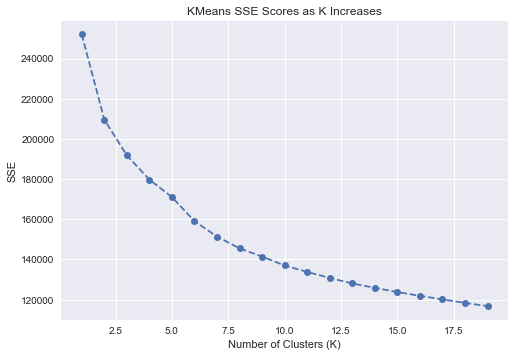

In [77]:
#Plotting results from the previous cell; noting that we begin seeing after about 6 clusters
centers = range(1, 20)
plt.plot(centers, scores, linestyle = '--', marker = 'o');
plt.style.use('seaborn');
plt.title('KMeans SSE Scores as K Increases');
plt.ylabel('SSE');
plt.xlabel('Number of Clusters (K)');

In [85]:
#Determining the silhouette score for the first 20 clusters
#Special thanks to this post for assistance: https://stackoverflow.com/questions/51149589/memorerror-while-calculating-silhouette-score

for i in range(2, 20):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(customer_transactions_master)
    clusters = kmeans.predict(customer_transactions_master)
    silhouette_avg = silhouette_score(customer_transactions_master, clusters)
    print("For n_clusters = ", i,"The avg silhouette_score is :", silhouette_avg)

For n_clusters =  2 The avg silhouette_score is : 0.15698941128814237
For n_clusters =  3 The avg silhouette_score is : 0.13427119202276
For n_clusters =  4 The avg silhouette_score is : 0.13488219332971987
For n_clusters =  5 The avg silhouette_score is : 0.11768868435263667
For n_clusters =  6 The avg silhouette_score is : 0.12344969115506356
For n_clusters =  7 The avg silhouette_score is : 0.12587930376251508
For n_clusters =  8 The avg silhouette_score is : 0.11720782781736412
For n_clusters =  9 The avg silhouette_score is : 0.12062524581312133
For n_clusters =  10 The avg silhouette_score is : 0.10764354206822273
For n_clusters =  11 The avg silhouette_score is : 0.10848069499502569
For n_clusters =  12 The avg silhouette_score is : 0.10597903597420155
For n_clusters =  13 The avg silhouette_score is : 0.10401624479641476
For n_clusters =  14 The avg silhouette_score is : 0.10378410165693669
For n_clusters =  15 The avg silhouette_score is : 0.10332614987699437
For n_clusters = 

#### Number of Clusters We Will Use: 4

Given both pieces here, we'll go ahead and leverage 4 clusters. Both the sihouette score and elbow method started showing diminishing returns following 4 clusters.

## Machine Learning Modeling - Round 2

Now that we've gone through and determined how to properly refine our model, let's use th insights from above to run our model again for more optimal results.

In [94]:
#Using the ward model, we'll append the results as a new column to our normalized master
ward_model = AgglomerativeClustering(n_clusters = 4)
customer_transactions_master['cluster'] = ward_model.fit_predict(customer_transactions_master)

In [95]:
customer_transactions_master.sample(10)

,age,avg_spent,bogo_percent_completed,completed_bogo,completed_discount,days_as_member,discount_percent_completed,gender,income,num_bogos,num_discounts,num_transactions,percent_completed,total_completed,total_received,total_spent,total_viewed,cluster
14702,-1.230707,-0.844584,-0.378410,-1.719354,-0.564313,-0.943434,2.698510,1.063557,-0.944782,-1.493353,-1.106325,-1.034512,-1.459474,-1.383232,-0.451989,-0.867787,-1.055732,3
263,0.667687,0.164186,-0.378410,-0.564000,0.582649,-0.285023,0.127918,1.063557,0.397962,-0.452891,0.275242,-0.455640,1.550019,0.512935,-1.382518,-0.073316,-1.055732,0
2689,-0.712963,0.494329,-1.429555,-0.564000,-0.564313,-0.802687,-0.157704,1.063557,1.138786,0.587572,-0.415542,-1.034512,1.550019,0.512935,-1.382518,-0.362249,-0.281302,2
14218,-1.115653,-0.707547,0.672734,-1.719354,0.582649,2.723152,-0.633739,1.063557,0.212756,-1.493353,1.656808,1.473934,0.797646,0.512935,-0.451989,-0.450122,0.493128,1
9160,-1.921032,-0.704097,3.826167,-1.719354,0.582649,2.346236,-0.633739,-0.842540,0.351660,-1.493353,1.656808,0.509147,-0.957892,-0.751176,1.409069,-0.586086,-1.055732,3
7246,-1.345761,-0.724245,-0.678737,0.591354,-0.564313,1.272740,2.698510,-0.842540,-1.176289,0.934392,-1.106325,0.702104,-0.957892,-0.751176,1.409069,-0.587933,-0.281302,3
14585,-0.080165,-0.668793,0.042047,0.591354,0.582649,-1.031699,2.698510,-0.842540,0.259057,0.240751,-0.760933,-0.648597,-0.857575,-0.751176,0.478540,-0.735362,-0.281302,3
6506,-0.022638,-0.712973,-1.079173,0.591354,-0.564313,-0.344661,-0.157704,-0.842540,-1.546701,1.628034,-0.415542,1.473934,-0.255677,-0.119121,0.478540,-0.461049,1.267558,2
5590,0.034889,-0.698262,0.672734,-0.564000,-0.564313,-0.380445,2.698510,-0.842540,0.166454,-0.799711,-1.106325,-1.227469,-1.459474,-1.383232,-2.313047,-0.841856,-1.830162,3
1337,0.495105,0.427485,0.672734,-0.564000,-0.564313,-0.564132,0.556350,-0.842540,0.536866,-0.799711,-0.760933,-1.034512,-1.459474,-1.383232,-2.313047,-0.387488,-1.055732,0


In [119]:
#Adding our clusters column back into our primary, unnormalized dataset for analyses
customer_transactions['cluster'] = customer_transactions_master['cluster']

In [120]:
customer_transactions.to_csv('customer_transactions_clusters.csv', index = False)

In [32]:
customer_transactions = pd.read_csv('customer_transactions_clusters.csv')

In [33]:
customer_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 21 columns):
age                           14825 non-null int64
age_range                     14825 non-null object
avg_spent                     14492 non-null float64
became_member_on              14825 non-null object
bogo_percent_completed        14825 non-null float64
completed_bogo                14825 non-null int64
completed_discount            14825 non-null int64
customer_id                   14825 non-null object
days_as_member                14825 non-null int64
discount_percent_completed    14825 non-null float64
gender                        14825 non-null int64
income                        14825 non-null float64
num_bogos                     14825 non-null int64
num_discounts                 14825 non-null int64
num_transactions              14825 non-null int64
percent_completed             14825 non-null float64
total_completed               14825 non-null int64
total_recei

## Final Analysis

Now that we've gathered our various clusters from our hierarchical algorithm, let's go ahead and visualize the results!

### Q5: What personal attributes of our customers are defined throughout each of our clusters?

First, let's take a look at the personal attributes of our customers as clustered by our algorithm. We'll visualize this first in a PairPlot and then further down in more easy to read diagrams.

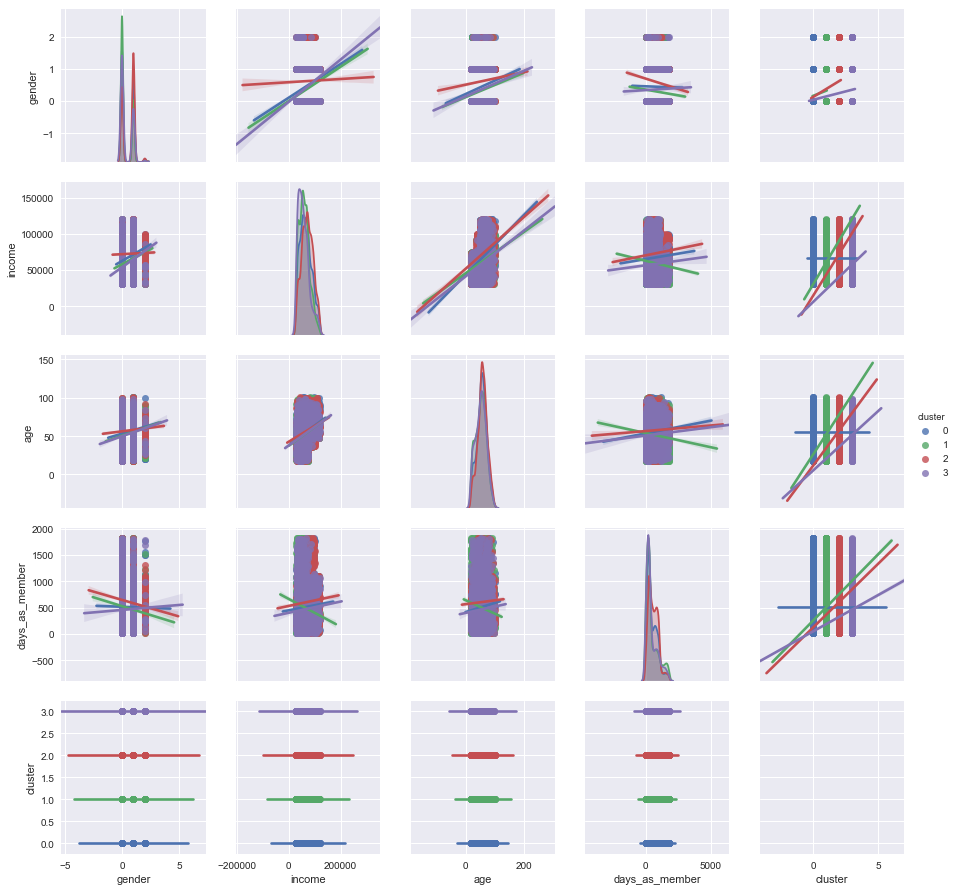

In [95]:
#Viewing personal customer details in a seaborn pairplot
#Special thanks to this for assistance: https://seaborn.pydata.org/generated/seaborn.pairplot.html
personal_details = ['gender', 'income', 'age', 'days_as_member', 'cluster']
sb.pairplot(customer_transactions[personal_details], hue = 'cluster', kind = 'reg');

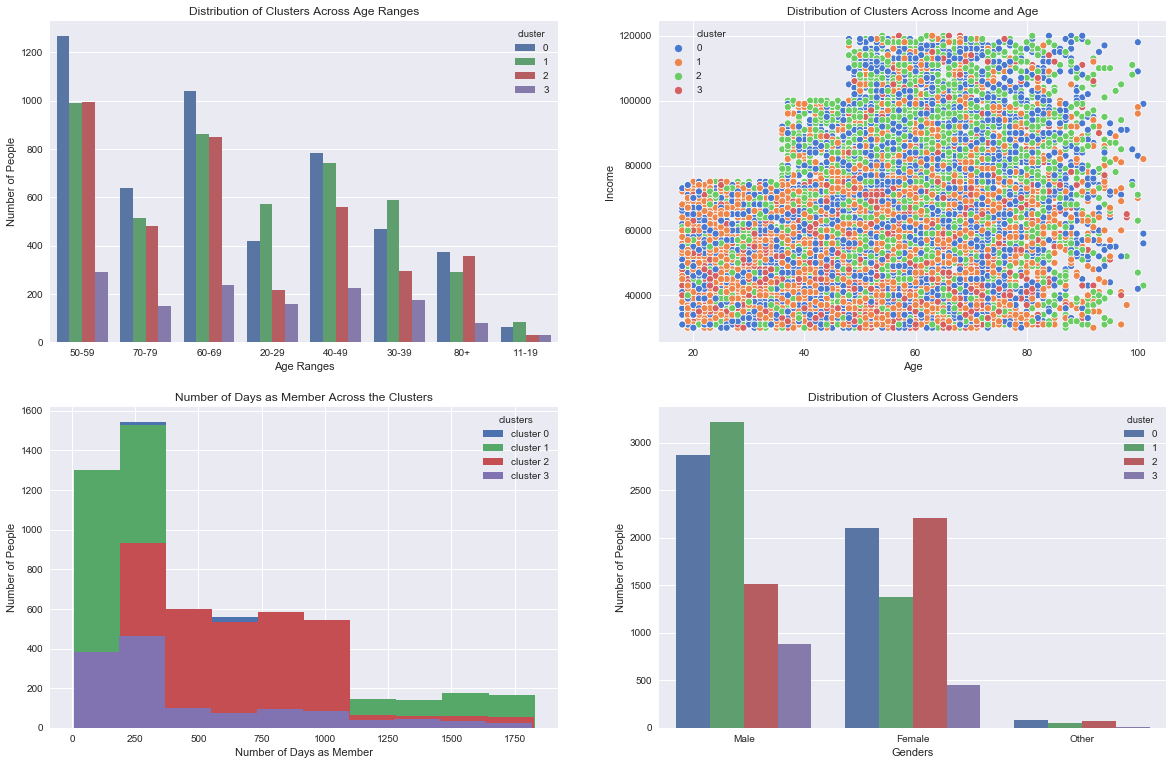

In [34]:
#Visualizing the personal details in closer details across each cluster
#Special thanks to this post for assistance: https://stackoverflow.com/questions/1358977/how-to-make-several-plots-on-a-single-page-using-matplotlib
#Special thanks to this post for assistance: https://stackoverflow.com/questions/19626530/python-xticks-in-subplots

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 13))

#Visualizing clusters across age ranges
sb.countplot(data = customer_transactions, x = 'age_range', hue = 'cluster', ax = axes[0,0]);
axes[0,0].set_title('Distribution of Clusters Across Age Ranges');
axes[0,0].set_xlabel('Age Ranges');
axes[0,0].set_ylabel('Number of People');

#Visualizing clusters across incomes and ages
sb.scatterplot(data = customer_transactions, x = 'age', y = 'income', hue = 'cluster', palette = sb.color_palette('muted', n_colors = 4), ax = axes[0,1]);
axes[0,1].set_title('Distribution of Clusters Across Income and Age');
axes[0,1].set_xlabel('Age');
axes[0,1].set_ylabel('Income');

#Visualizing how long members have been members in a stacked histogram
days_as_member_0 = customer_transactions[customer_transactions['cluster'] == 0]['days_as_member']
days_as_member_1 = customer_transactions[customer_transactions['cluster'] == 1]['days_as_member']
days_as_member_2 = customer_transactions[customer_transactions['cluster'] == 2]['days_as_member']
days_as_member_3 = customer_transactions[customer_transactions['cluster'] == 3]['days_as_member']
axes[1,0].hist(days_as_member_0, stacked = True);
axes[1,0].hist(days_as_member_1, stacked = True);
axes[1,0].hist(days_as_member_2, stacked = True);
axes[1,0].hist(days_as_member_3, stacked = True);
axes[1,0].legend(title = 'clusters', labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']);
axes[1,0].set_title('Number of Days as Member Across the Clusters');
axes[1,0].set_xlabel('Number of Days as Member');
axes[1,0].set_ylabel('Number of People');

#Visualizing clusters across age ranges
sb.countplot(data = customer_transactions, x = 'gender', hue = 'cluster', ax = axes[1,1]);
axes[1,1].set_title('Distribution of Clusters Across Genders');
axes[1,1].set_xlabel('Genders');
axes[1,1].set_ylabel('Number of People');
plt.sca(axes[1,1]);
plt.xticks(range(3), ['Male', 'Female', 'Other']);

### A5: Analysis of Clustered Personal Attributes

Lots of great insights here! Let's cover each of the respective clusters within the respective sections below.

#### Cluster 0
Easily the largest cluster, cluster 0 tended to consist of older people with higher incomes. As evidenced by our countplot with the age ranges, the ages of these folks typcally fell into that 50 to 80 year old range. Additionally, it was somewhat common to see these folks have some of the higher income ranges. Gender was somewhat evenly split between males and females, and I would probably only account the difference as the fact that the original dataset had more men to begin with, anyway. Admittedly, however, because this cluster was the biggest, it had a lot of discrepancies (particularly with income) that make it questionable how much to rely upon it for future inference.

#### Cluster 1
This cluster seems to be the young person's cluster. Looking at the age range distribution, we see the strongest distrubution here amongst the 20-40 year old crowd. Interestingly, the gap between males and females is quite large in this cluster. These folks also tend to fall toward the lower end when it comes to income. And as far as number of days as member goes, this cluster's distribution is very similar to that of cluster 0.

#### Cluster 2
This cluster here has a couple of interesting highlights. First, this is the only customer where there were more males than females, and this cluster also contained the largest distribution of people who have been members of the Starbucks rewards program for some time. Income tended to be higher here which is not surprising given that our EDA showed us that women tended to make more than men.

#### Cluster 3
Finally, this last cluster is easily the smallest of our four clusters, yet it bears some striking similarites to cluster 0 in a few ways. Namely, the distribution of days as member and gender are fairly similar. Perhaps the exception that separates it from cluster 0 is that there tended to be more people in the younger age range, and I suppose that would make sense given that younger people consisted of a smaller subset of the original data provided.

### Q6: What do the behavioral attributes look like across our clusters?

Finally, let's wrap up our analysis by looking at the clusters across some of the more behavioral attributes.

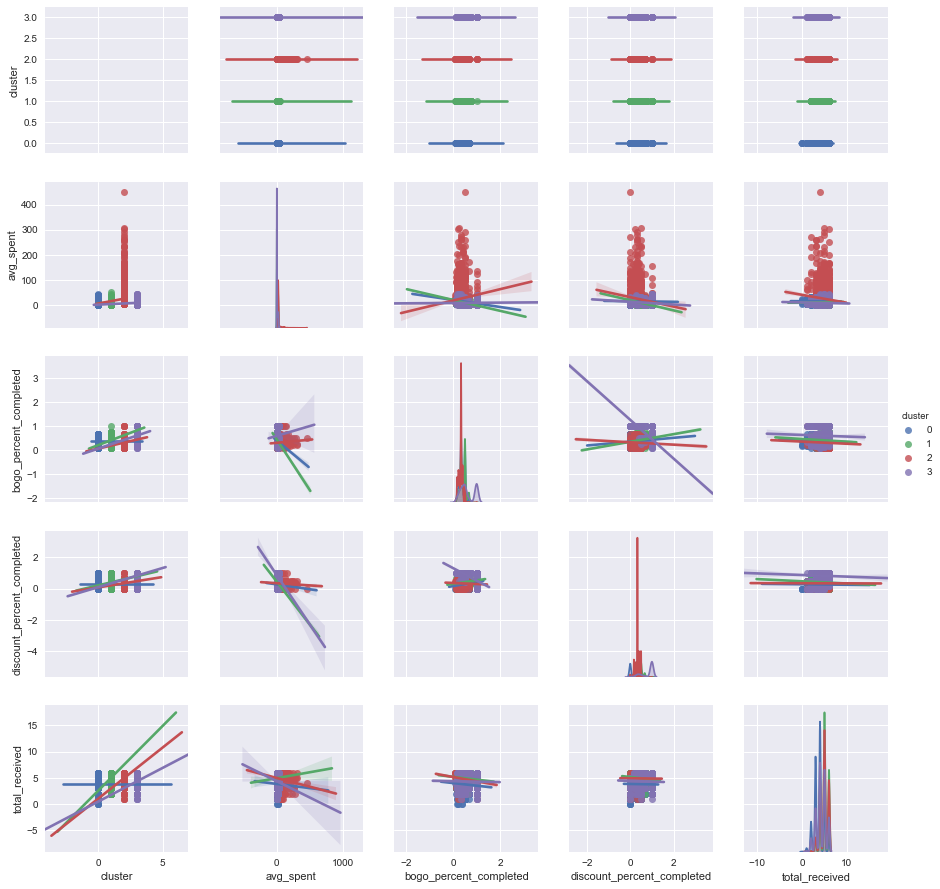

In [36]:
behavioral_attributes = ['cluster', 'avg_spent', 'bogo_percent_completed', 'discount_percent_completed', 'total_received']
sb.pairplot(customer_transactions[behavioral_attributes], hue = 'cluster', kind = 'reg');

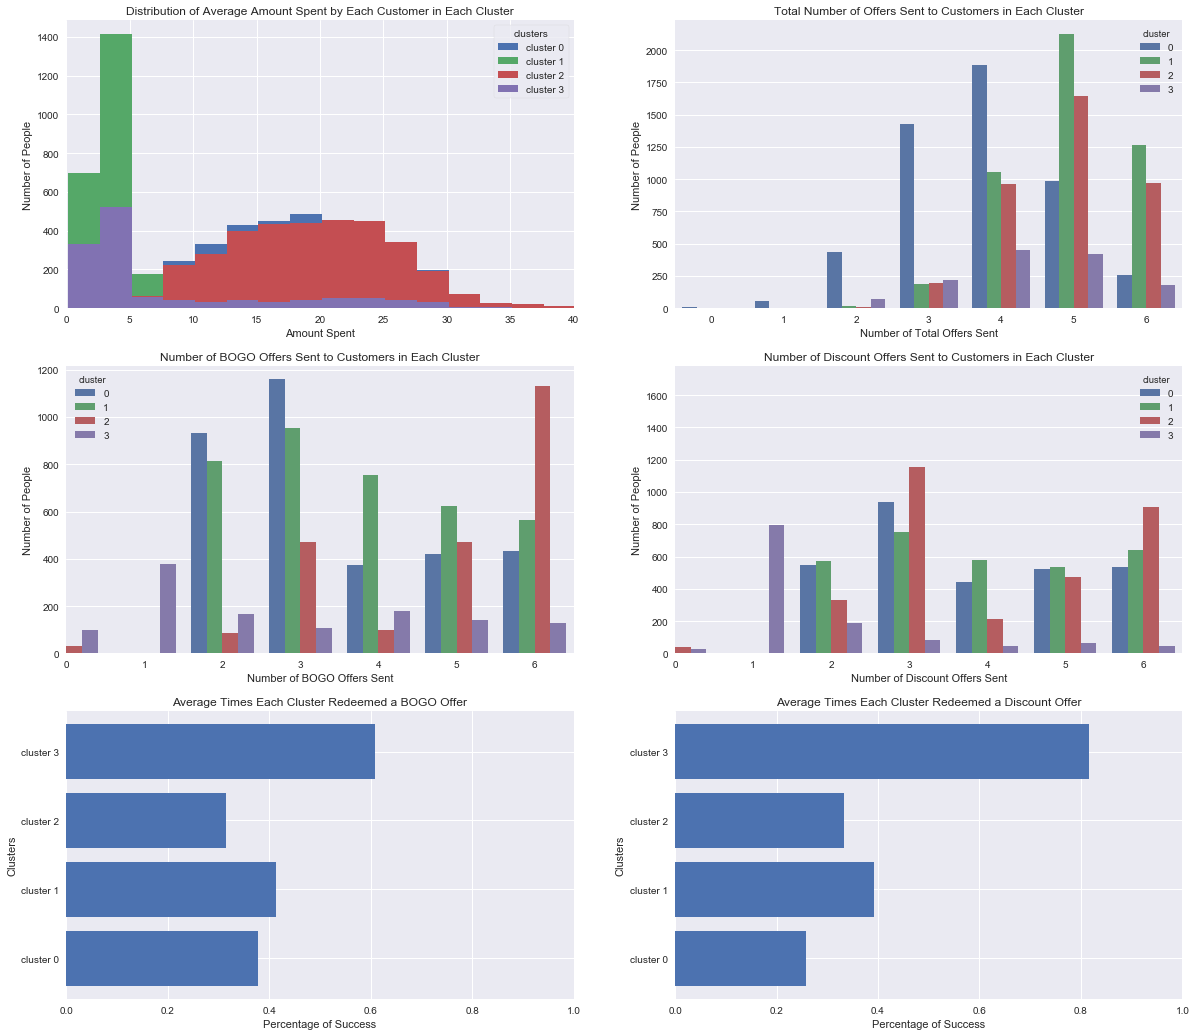

In [91]:
#Visualizing the behavioral attributes in more detail
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 18))

#Visualizing the average amount spent by customers in each respective cluster
avg_spent_0 = customer_transactions[customer_transactions['cluster'] == 0]['avg_spent']
avg_spent_1 = customer_transactions[customer_transactions['cluster'] == 1]['avg_spent']
avg_spent_2 = customer_transactions[customer_transactions['cluster'] == 2]['avg_spent']
avg_spent_3 = customer_transactions[customer_transactions['cluster'] == 3]['avg_spent']
avg_spent_bins = np.arange(min(customer_transactions['avg_spent']), max(customer_transactions['avg_spent'] + 2.5), 2.5)
axes[0,0].hist(avg_spent_0, bins = avg_spent_bins, stacked = True);
axes[0,0].hist(avg_spent_1, bins = avg_spent_bins, stacked = True);
axes[0,0].hist(avg_spent_2, bins = avg_spent_bins, stacked = True);
axes[0,0].hist(avg_spent_3, bins = avg_spent_bins, stacked = True);
axes[0,0].set_xlim([0, 40]);
axes[0,0].legend(title = 'clusters', labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'], frameon = True);
axes[0,0].set_title('Distribution of Average Amount Spent by Each Customer in Each Cluster');
axes[0,0].set_xlabel('Amount Spent');
axes[0,0].set_ylabel('Number of People');

#Visualizing the total number of offers sent to the customers
sb.countplot(data = customer_transactions, x = 'total_received', hue = 'cluster', ax = axes[0,1]);
axes[0,1].set_title('Total Number of Offers Sent to Customers in Each Cluster');
axes[0,1].set_xlabel('Number of Total Offers Sent');
axes[0,1].set_ylabel('Number of People');

#Visualizing the number of BOGO offers sent to the customers
sb.countplot(data = customer_transactions, x = 'num_bogos', hue = 'cluster', ax = axes[1,0]);
axes[1,0].set_title('Number of BOGO Offers Sent to Customers in Each Cluster');
axes[1,0].set_xlabel('Number of BOGO Offers Sent');
axes[1,0].set_ylabel('Number of People');
axes[1,0].set_xlim([0, 6.5]);

#Visualizing the number of discount offers sent to the customers
sb.countplot(data = customer_transactions, x = 'num_discounts', hue = 'cluster', ax = axes[1,1]);
axes[1,1].set_title('Number of Discount Offers Sent to Customers in Each Cluster');
axes[1,1].set_xlabel('Number of Discount Offers Sent');
axes[1,1].set_ylabel('Number of People');
axes[1,1].set_xlim([0, 6.5]);

#Visualizing the mean of the how often customers completed bogo offers in each cluster
bogo_pct_completed_0 = customer_transactions[customer_transactions['cluster'] == 0]['bogo_percent_completed'].mean()
bogo_pct_completed_1 = customer_transactions[customer_transactions['cluster'] == 1]['bogo_percent_completed'].mean()
bogo_pct_completed_2 = customer_transactions[customer_transactions['cluster'] == 2]['bogo_percent_completed'].mean()
bogo_pct_completed_3 = customer_transactions[customer_transactions['cluster'] == 3]['bogo_percent_completed'].mean()
bogo_pct_completed_data = [bogo_pct_completed_0, bogo_pct_completed_1, bogo_pct_completed_2, bogo_pct_completed_3]
y_pos = np.arange(len(bogo_pct_completed_data))
bogo_tick_labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
axes[2,0].barh(y_pos, bogo_pct_completed_data, tick_label = bogo_tick_labels);
axes[2,0].set_xlim([0, 1]);
axes[2,0].set_title('Average Times Each Cluster Redeemed a BOGO Offer');
axes[2,0].set_xlabel('Percentage of Success');
axes[2,0].set_ylabel('Clusters');

#Visualizing the mean of the how often customers completed discount offers in each cluster
discount_pct_completed_0 = customer_transactions[customer_transactions['cluster'] == 0]['discount_percent_completed'].mean()
discount_pct_completed_1 = customer_transactions[customer_transactions['cluster'] == 1]['discount_percent_completed'].mean()
discount_pct_completed_2 = customer_transactions[customer_transactions['cluster'] == 2]['discount_percent_completed'].mean()
discount_pct_completed_3 = customer_transactions[customer_transactions['cluster'] == 3]['discount_percent_completed'].mean()
discount_pct_completed_data = [discount_pct_completed_0, discount_pct_completed_1, discount_pct_completed_2, discount_pct_completed_3]
y_pos = np.arange(len(discount_pct_completed_data))
discount_tick_labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
axes[2,1].barh(y_pos, discount_pct_completed_data, tick_label = discount_tick_labels);
axes[2,1].set_xlim([0, 1]);
axes[2,1].set_title('Average Times Each Cluster Redeemed a Discount Offer');
axes[2,1].set_xlabel('Percentage of Success');
axes[2,1].set_ylabel('Clusters');


#discount_percent_cmompleted
#bogo_percent_completed

### A6: Analysis of Clustered Behavioral Attributes

Even more fascinating stuff in here. Let's cover each of the respective clusters within the respective sections below.

#### Cluster 0
Lots of interesting things to note in here. First, this cluster on average seems to be the biggest spenders, with an average transaction total peaking at ~\\$19. I noted earlier on in the report that I felt that this amount is really high, but now that I think about it, maybe it's on point. Remember, this particular cluster contains our older customers, and perhaps these customers are buying for multiple people, like family members or friends. Considering that, perhaps that average number makes more sense.

Interestingly, this cluster has the lowest yield of using discount offers and pretty close to last for BOGO offers. It's also interesting to note that Starbucks almost caps out how many offers they send to these folks. We have a lot of people reporting receiving 2-3 offers, and that number falls off big time after that. Is it because Starbucks is tired of trying to appeal to a group that doesn't take advantage of these offers? Not to try stereotyping older folks too much, but they do tend toward not leveraging technology as well. Is it because these offers are being managed electronically? More on this down in cluster 3.

#### Cluster 1
Recalling from above that this cluster tends toward a younger crowd, we see things like the average amount spent spike toward the lower end. Interestingly, we also see that this particular group gets hit hard with offers, spiking big time around 5 offers sent. Taking a closer look, it looks like there's a stronger leaning toward BOGO offers over discount offers. In both cases, the success percentage for both is about equal, hovering around 40\%. This number isn't necessarily great, and it's not clear why this is the case. Perhaps the difficulty levels for these rewards are too high for this cluster's general demographics.

#### Cluster 2
Our predominantly female cluster, this group also has a high spend amount, much akin to cluster 0. This cluster is hit pretty strongly with a lot of offers, especially BOGO offers. I'm not sure why this is necessarily the case since the cluster doesn't tend to react well to these clusters, noting the lowest BOGO success precentage at about 25\%. I think there's definitely a lot of opportunity for improvement here given the demographic information of this group and current low success rating across both offers.

#### Cluster 3
This group is the most curious of all. Recall from the previous section that this group's demographics closely aligned to that of cluster 0's with the exception that this group tends a little younger than the cluster 0's folks. I say that this group is curious because of how high of a success rate this group has with offers, especially with discount based offers. Now granted, this cluster is definitely the smallest of the bunch, but that doesn't negate the fact that something is definitely working. Perhaps Starbucks could lean into leaning more about this cluster to discover what is causing the level of success.